In [142]:
config={
    "nodes":[[86,99],[100,145],[61,168],[169,229],[230,104],[105,465],[466,85]],
    "activity":["navigation","roadblocked","parking","overtaking","highway","oneway","finish"]
}

In [143]:
import networkx as nx
from copy import deepcopy
import math
import numpy as np
from tqdm import tqdm
import joblib

In [144]:
import matplotlib.pyplot as plt

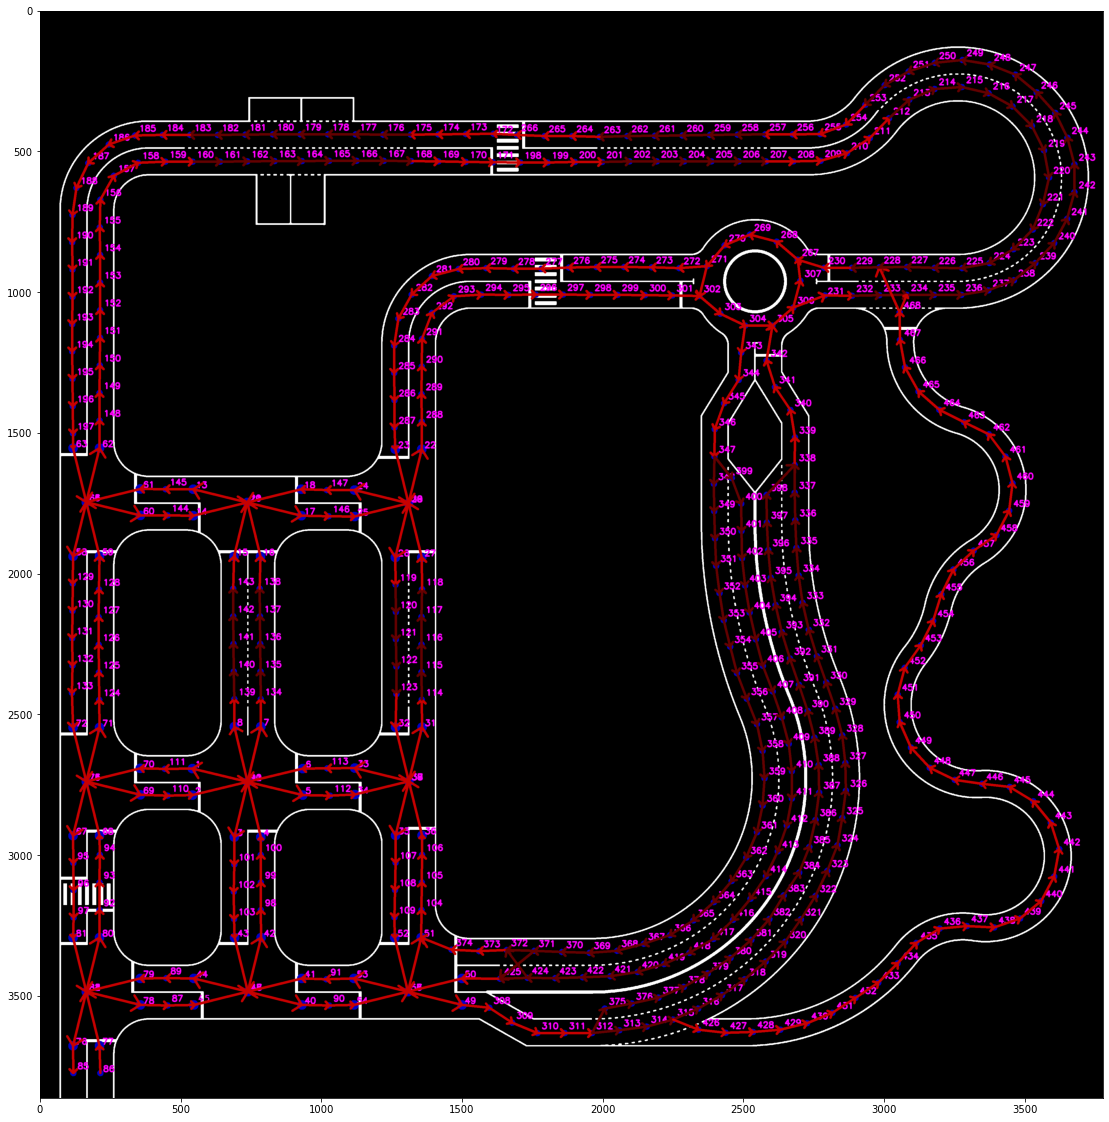

In [145]:
G = nx.read_graphml('comp_track.graphml')
import cv2
plt.figure(figsize=(20,20))
img=cv2.imread("Competition_track.png")
plt.imshow(img)

In [146]:
roundabout_pts=['267','268','269','270','271','302','303','304','305','306','307']

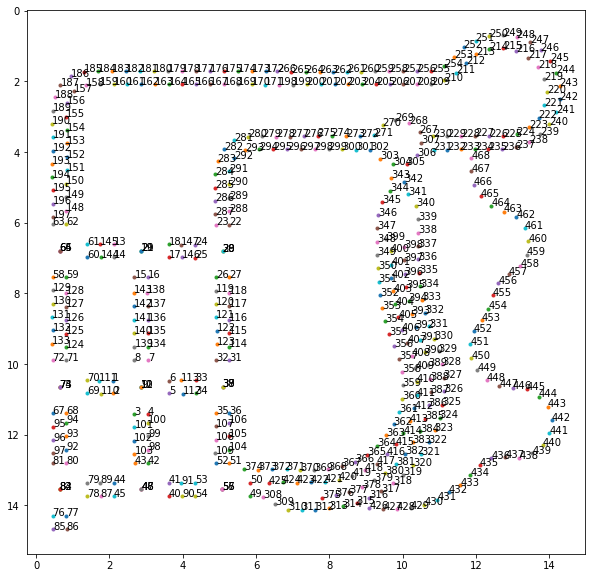

In [147]:
plt.figure(figsize=(10,10))
for node,data in G.nodes(data=True):
    plt.plot(data['x'],data['y'],'.')
    ax = plt.gca()
    ax.annotate(str(node), (data['x'],data['y'])) 

ax = plt.gca()
ax.invert_yaxis()

In [148]:
import heapq

def dijkstra(G, start, target):
    d = {start: 0}
    parent = {start: None}
    pq = [(0, start)]
    visited = set()
    while pq:
        du, u = heapq.heappop(pq)
        if u in visited:
            continue
        if u == target:
            break
        visited.add(u)
        for v  in G.adj[u]:
            if v not in d or d[v] > du + 1:
                d[v] = du + 1
                parent[v] = u
                heapq.heappush(pq, (d[v], v))

    
    fp = [target]
    tg = target
    ptype=[("lk" if len([i for i in G.neighbors(tg)])<2 else "int")]
    
    roundabout_pts=['267','268','269','270','271','302','303','304','305','306','307']
    
    while tg != start:
        fp.insert(0, parent[tg])
        tg = parent[tg]
        ptype.insert(0,("lk" if len([i for i in G.neighbors(tg)])<2 else "int"))
        # print([i for i in G.neighbors(tg)])
        
   
    
    
    ptyperet=ptype.copy()
    for i in range(len(ptype)):
        if ptype[i]=='int':
            try:
                ptyperet[i-1]="int"
            except:
                pass
            try:
                ptyperet[i+1]="int"
                i+=1
            except:
                pass
    
    for i in range(len(ptyperet)):
        if fp[i] in roundabout_pts:
            ptyperet[i]="roundabout"
    
    edgeret=[]
    
    for i in range(len(fp)-1):
        dt=G.get_edge_data(fp[i],fp[i+1])
        edgeret.append(dt['dotted'])
        
    edgeret.append(None)
        
            
    return fp,ptyperet,edgeret

In [149]:
def isLeft(A,B,isleftpoint):
    yd=math.atan2(B[1]-A[1],B[0]-A[0])
    yd2=math.atan2(isleftpoint[1]-A[1],isleftpoint[0]-A[0])
    compute=yd-yd2
    
    if abs(compute)>math.pi:
        if compute >0:
            compute=abs(compute)-2*math.pi
        else:
            compute=2*math.pi-abs(compute)
    # print(compute)
    if compute >= 0:
        # print("True")
        return True,compute
    else:
        # print("False")
        return False,compute

def isSmoothNeeded(A,B,refcoord):
    yd=math.atan2(B[1]-A[1],B[0]-A[0])
    yd2=math.atan2(refcoord[1]-A[1],refcoord[0]-A[0])
    compute=yd-yd2
    if abs(compute)>math.pi:
        if compute >0:
            compute=abs(compute)-2*math.pi
        else:
            compute=2*math.pi-abs(compute)
    if abs(compute)>0.05:
        return True
    

def _smooth_point_list(coord_list1, ptype,etype) :
        coord_list=[]
        for i in coord_list1:
            data=node_dict[i]
            coord_list.append([data['x'],data['y']]) 
        coordlist_new = []
        count = 0
        sizeincrease=0
        countfinal = len(coord_list)
        # print(countfinal)
        ptype_new=ptype.copy()
        etype_new=etype.copy()

        while count < countfinal:
            if ptype[count] == "int":
                # append first point
                coordlist_new.append(coord_list[count])
                # find midpoint of intersection start and end
                xmidint = (coord_list[count][0] + coord_list[count + 2][0]) / 2
                ymidint = (coord_list[count][1] + coord_list[count + 2][1]) / 2
                
                
                
                flag,value=isLeft(coord_list[count],coord_list[count+1],coord_list[count+2])
                
                if flag and abs(value)>0.3:
                    xfinmid = (xmidint + coord_list[count + 1][0]*5) / 6
                    yfinmid = (ymidint + coord_list[count + 1][1]*5) / 6
                    pts=[coord_list[count],(xfinmid,yfinmid),coord_list[count+2]]
                elif not flag and abs(value)>0.3:
                    xfinmid = (xmidint*2 + coord_list[count + 1][0]) / 3
                    yfinmid = (ymidint*2 + coord_list[count + 1][1]) / 3
                    pts=[coord_list[count],(xfinmid,yfinmid),coord_list[count+2]]
                    
                else:
                    pts=[coord_list[count],coord_list[count+2]]
                    
                
                

                x,y=zip(*pts)
                
                i = np.arange(len(x))

                cx,cy,_,_,_=cubic_spline_planner.calc_spline_course(x,y,0.15)

                for i in range(len(cx)):
                    coordlist_new.append((cx[i],cy[i]))
                    ptype_new.insert(count+sizeincrease,"int")
                    etype_new.insert(count+sizeincrease,False)
                    sizeincrease+=1
                
                
                coordlist_new.append(coord_list[count+2])
                coordlist_new.append(coord_list[count+2])
                count+=3
            elif ptype[count]=="lk" and count<countfinal-2 and ptype[count+1]=="lk" and isSmoothNeeded(coord_list[count],coord_list[count+1],coord_list[count+2]):
                pts=[coord_list[count],coord_list[count+1],coord_list[count+2]]
                x,y=zip(*pts)
                
                i = np.arange(len(x))

                cx,cy,_,_,_=cubic_spline_planner.calc_spline_course(x,y,0.15)

                for i in range(len(cx)):
                    coordlist_new.append((cx[i],cy[i]))
                    ptype_new.insert(count+sizeincrease,"lk")
                    etype_new.insert(count+sizeincrease,False)
                    sizeincrease+=1
                coordlist_new.append(coord_list[count+2])
                coordlist_new.append(coord_list[count+2])
                coordlist_new.append(coord_list[count+2])
                count+=3
            else:
                coordlist_new.append(coord_list[count])
                count += 1

        return coordlist_new,ptype_new,etype_new

In [1]:
def _smooth_point_list_o(G,coord_list1, ptype,etype) :
        node_dict = deepcopy(dict(G.nodes(data=True)))
        coord_list=[]
        for i in coord_list1:
            data=node_dict[i]
            coord_list.append([data['x'],data['y']]) 
        coordlist_new = []
        count = 0
        sizeincrease=0
        countfinal = len(coord_list)
        # print(countfinal)
        ptype_new=ptype.copy()
        etype_new=etype.copy()

        while count < countfinal:
            if ptype[count] == "int":
                # append first point
                coordlist_new.append(coord_list[count])
                # find midpoint of intersection start and end
                xmidint = (coord_list[count][0] + coord_list[count + 2][0]) / 2
                ymidint = (coord_list[count][1] + coord_list[count + 2][1]) / 2
                
                
                
                flag,value=isLeft(coord_list[count],coord_list[count+1],coord_list[count+2])
                
                if flag and abs(value)>0.3:
                    xfinmid = (xmidint + coord_list[count + 1][0]*5) / 6
                    yfinmid = (ymidint + coord_list[count + 1][1]*5) / 6
                    pts=[coord_list[count],(xfinmid,yfinmid),coord_list[count+2]]
                elif not flag and abs(value)>0.3:
                    xfinmid = (xmidint*2 + coord_list[count + 1][0]) / 3
                    yfinmid = (ymidint*2 + coord_list[count + 1][1]) / 3
                    pts=[coord_list[count],(xfinmid,yfinmid),coord_list[count+2]]
                    
                else:
                    pts=[coord_list[count],coord_list[count+2]]
                    
                
                

                x,y=zip(*pts)
                
                i = np.arange(len(x))

                cx,cy,_,_,_=cubic_spline_planner.calc_spline_course(x,y,0.15)

                for i in range(len(cx)):
                    coordlist_new.append((cx[i],cy[i]))
                    ptype_new.insert(count+sizeincrease,"int")
                    etype_new.insert(count+sizeincrease,False)
                    sizeincrease+=1
                
                
                coordlist_new.append(coord_list[count+2])
                coordlist_new.append(coord_list[count+2])
                count+=3
            elif ptype[count]=="lk" or  ptype[count]=="roundabout":
                icount=count
                pts=[]
                while True:
                    if ptype[count]!="lk" and ptype[count]!="roundabout":
                        "broke"
                        break
                    pts.append(coord_list[count])
                    count+=1
                    if count>=countfinal:
                        break
                # print(pts)
                
                if len(pts)==1:
                    coordlist_new.append(coord_list[icount])
                    # ptype_new.insert(icount,"lk")
                    # etype_new.insert(icount,False)
                    continue
                    
                x,y=zip(*pts)
                
                i = np.arange(len(x))

                cx,cy,_,_,_=cubic_spline_planner.calc_spline_course(x,y,0.15)

                for i in range(len(cx)):
                    coordlist_new.append((cx[i],cy[i]))

                windowsize=len(cx)//(count-icount)
                    
                incrementor=0    
                for i in range(len(cx)-(count-icount)):
                    # add incrementor increment logic
                    if sizeincrease>windowsize*(incrementor+1) and incrementor!=(count-icount):
                        incrementor+=1
                    ptype_new.insert(icount+sizeincrease,"lk")
                    if len(etype)<icount+incrementor-1:
                        etype_new.insert(icount+sizeincrease,etype[icount+incrementor])
                    else:
                        etype_new.insert(icount+sizeincrease,etype[icount+incrementor-1])
                    sizeincrease+=1
                    
            else:
                coordlist_new.append(coord_list[count])
                count += 1

        return coordlist_new,ptype_new,etype_new

In [2]:
for i in range(len(config["nodes"])):
    print(config["nodes"][i],config["activity"][i])

NameError: name 'config' is not defined

In [258]:
import math
import cubic_spline_planner
node_dict=G.nodes(data=True)
class Path:
    def __init__(self):
        self.coords=[]
        self.ptype=[]
        self.etype=[]
        self.activity=[]
        self.yaw=[]
        self.area_dict_list=[]
    def add_yaw(self):
        for i in range(len(self.coords)):
            # print(i)
            try:
                y=self.coords[i+1][1]-self.coords[i][1]
                x=self.coords[i+1][0]-self.coords[i][0]
                # if x==0:
                #     x=0.0001
                self.yaw.append(math.atan2(y,x))
            except Exception as e:
                print("in exception",e)
                self.yaw.append(0)
pathobj=Path()

In [259]:
first=True
for i in range(len(config["nodes"])):
    # print(config["nodes"][i],config["activity"][i])
    c,p,e=_smooth_point_list_o(*dijkstra(G,str(config["nodes"][i][0]),str(config["nodes"][i][1])))
    
    a=[config["activity"][i] for j in c]
    print(len(c),len(e),len(p),len(a))
    assert len(c)==len(e)==len(p)==len(a)
    
    pdict={
        "c":c,
        "p":p,
        "e":e,
        "a":a
    }
    pathobj.coords.extend(c)
    pathobj.ptype.extend(p)
    pathobj.etype.extend(e)
    pathobj.activity.extend(a)
    pathobj.area_dict_list.append(pdict)
    first=False
pathobj.add_yaw()
    

28 28 28 28
40 40 40 40
61 61 61 61
86 86 86 86
107 107 107 107
184 184 184 184
149 149 149 149
in exception list index out of range


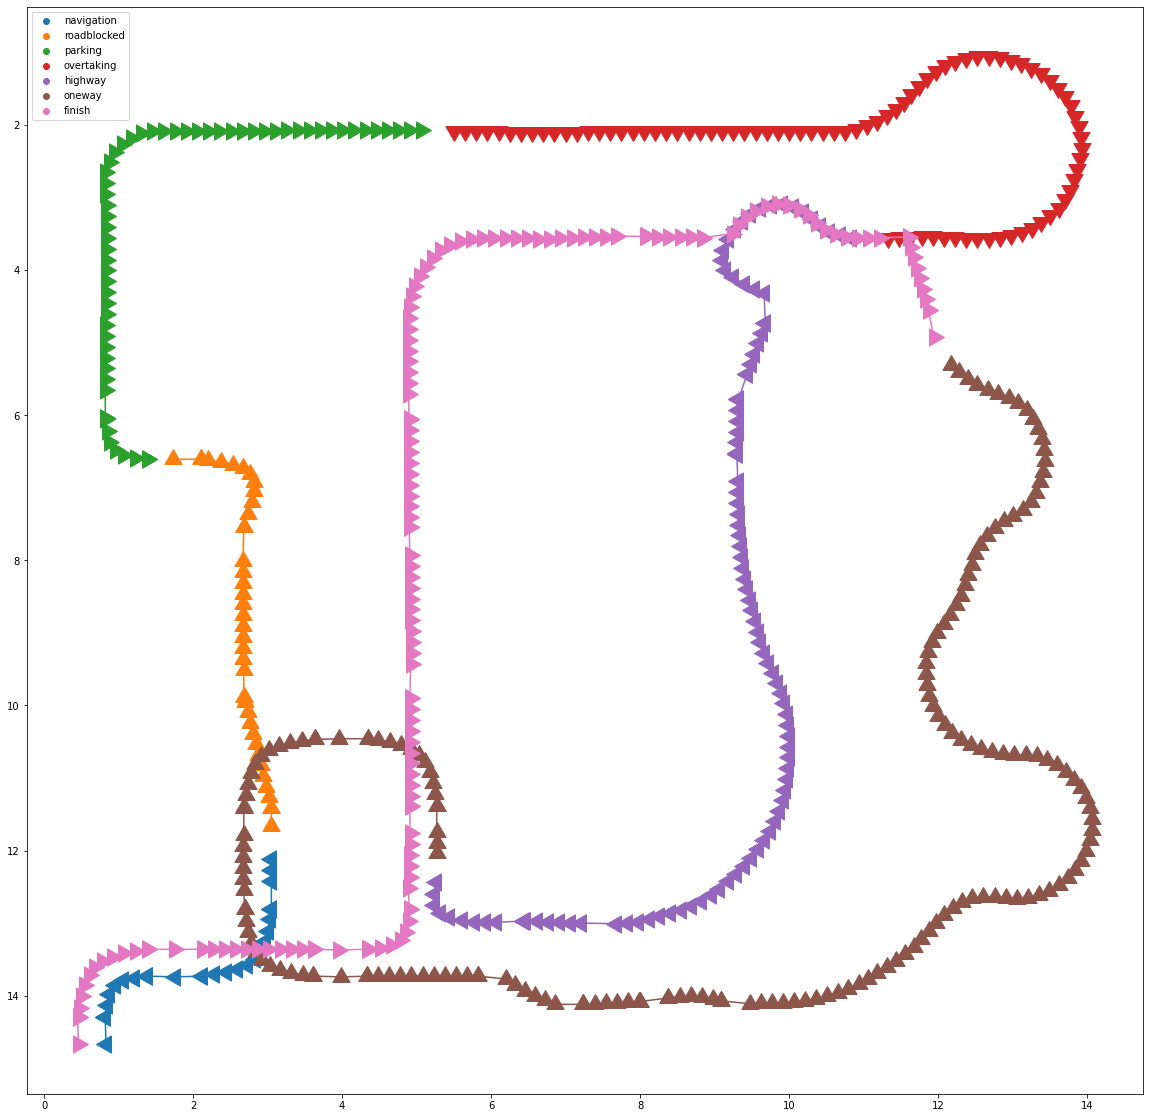

In [260]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
count=0
for i in pathobj.area_dict_list:
    x,y=zip(*i['c'])
    plt.scatter(x,y,label=i['a'][0])
    plt.plot(x,y,marker=(3,0,(90+30*count)),markersize=20)
    count+=1
# x,y=zip(*pathobj.coords)
# plt.plot(x,y,"r*")
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("plannedpath.png")

In [245]:
set(pathobj.ptype)

{'int', 'lk', 'roundabout'}

In [246]:
# pathobj.ptype

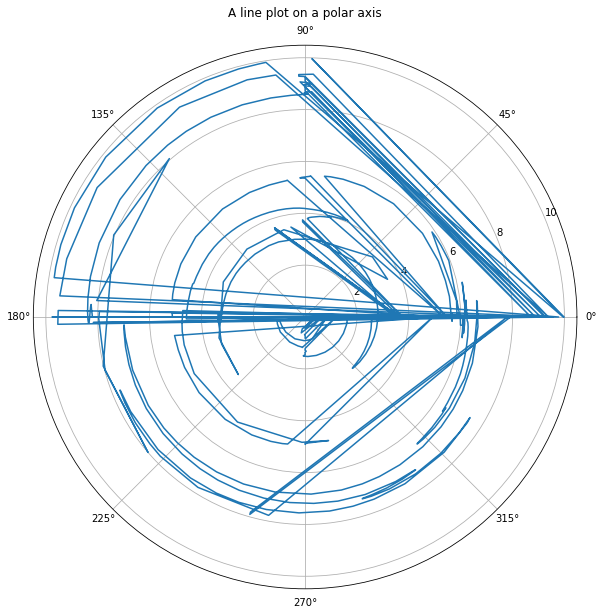

In [247]:
import numpy as np
import matplotlib.pyplot as plt


r = np.arange(0, 10, 10/len(pathobj.coords))
# theta = 2 * np.pi * r

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(10,10))
ax.plot(pathobj.yaw,r)
# ax.set_rmax(25)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

In [248]:
# pathobj.coords

In [249]:
len(pathobj.coords),len(pathobj.yaw)

(635, 635)

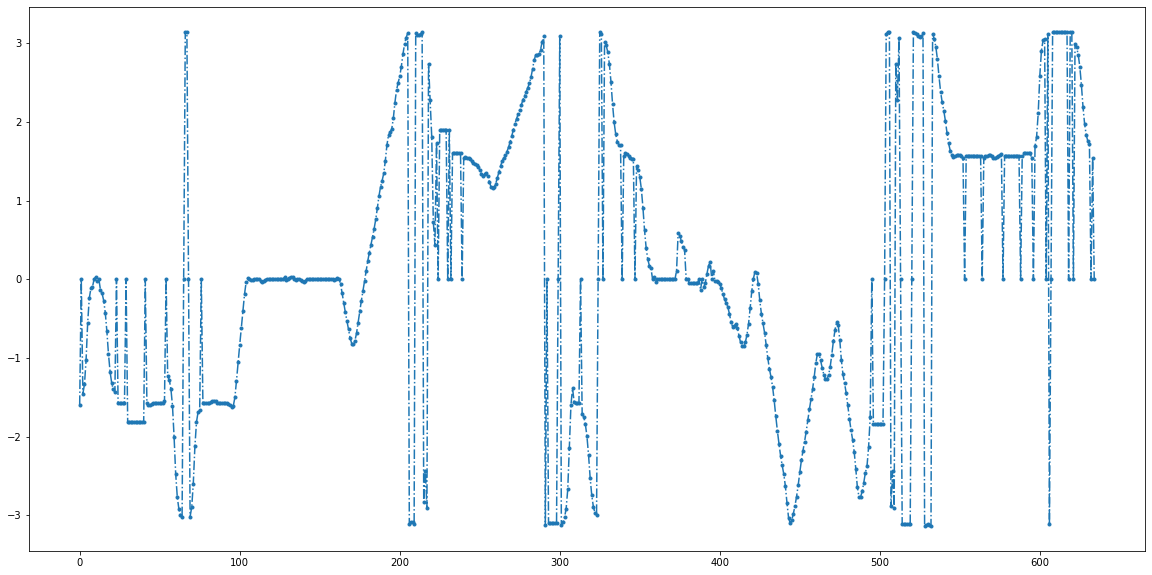

In [250]:
plt.figure(figsize=(20,10))
plt.plot(pathobj.yaw,".-.")

In [179]:
1/223

0.004484304932735426